In [24]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

%matplotlib inline

In [2]:
def save_model(classifier, model_type, n_est, hz):
    import m2cgen as m2c
    code = m2c.export_to_python(classifier)
    PATH = f'models/inf_time_test/{model_type}/{model_type}_{n_est}est_{hz}hz.py'
    with open(PATH,'w') as f:
        f.writelines(code)

    return PATH

In [3]:
def train_random_forest(X_train, X_test, y_train, y_test, n_est, hz):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics
    
    clf = RandomForestClassifier(random_state=42, n_estimators=n_est)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')

    path = save_model(classifier=clf, model_type='random_forest', n_est=n_est, hz=hz)

    return accuracy, f1, precision, recall, clf

In [4]:
collect_metrics = {}
collect_metrics['random_forest'] = {}

# ONLY 50hz data will be used
# Train on all data - not intersted in performance

df = pd.read_csv('data/transformed/20210529_v2_data_all_50hz.csv').reset_index(drop=True)
df_train = df.dropna(axis=0)

print('DF Shape', df_train.shape)
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

DF Shape (3340, 308)


In [8]:
for n_est in [3,4,5,6,7,8,9,10]:
    print(f'\nRandom Forest: {n_est}')
    train_random_forest(X_train, X_test, y_train, y_test, n_est, 50)
    print('-' * 60)


Random Forest: 3
------------------------------------------------------------

Random Forest: 4
------------------------------------------------------------

Random Forest: 5
------------------------------------------------------------

Random Forest: 6
------------------------------------------------------------

Random Forest: 7
------------------------------------------------------------

Random Forest: 8
------------------------------------------------------------

Random Forest: 9
------------------------------------------------------------

Random Forest: 10
------------------------------------------------------------


In [9]:
from models.inf_time_test.random_forest import (
        random_forest_3est_50hz,
        random_forest_4est_50hz,
        random_forest_5est_50hz, 
        random_forest_6est_50hz, 
        random_forest_7est_50hz, 
        random_forest_8est_50hz, 
        random_forest_9est_50hz, 
        random_forest_10est_50hz
    )

In [11]:
test_data_50hz = pd.read_csv('data/transformed/20210529_v2_data_all_50hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]

In [27]:
m2c_time_test_setup = {
    'random_forest': [
        (random_forest_3est_50hz, test_data_50hz, 3),
        (random_forest_4est_50hz, test_data_50hz, 4),
        (random_forest_5est_50hz, test_data_50hz, 5),
        (random_forest_6est_50hz, test_data_50hz, 6),
        (random_forest_7est_50hz, test_data_50hz, 7),
        (random_forest_8est_50hz, test_data_50hz, 8),
        (random_forest_9est_50hz, test_data_50hz, 9),
        (random_forest_10est_50hz, test_data_50hz, 10)
    ]
}

In [16]:
from statistics import mean

m2c_time_data_rf = {}            

for t_item in m2c_time_test_setup['random_forest']:

    model = t_item[0]
    test_data = t_item[1]
    n_est = t_item[2]
    res_time = get_ipython().run_line_magic('timeit', '-o model.score(test_data)')

    m2c_time_data_rf[k][n_est] = mean(res_time.timings)

38.6 µs ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
50.5 µs ± 1.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
66.5 µs ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
70.2 µs ± 3.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
83.6 µs ± 7.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
94 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
104 µs ± 6.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
115 µs ± 2.72 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
m2c_df = pd.DataFrame(m2c_time_data_rf)
m2c_df['model_type'] = 'm2c'
m2c_df = m2c_df.reset_index().rename(columns={'index':'estimators'})
m2c_df.to_csv('output/inference_time_rf_estimators_50hz.csv', index=False)

In [26]:
m2c_df

,estimators,random_forest,model_type
0,50,0.000115,m2c


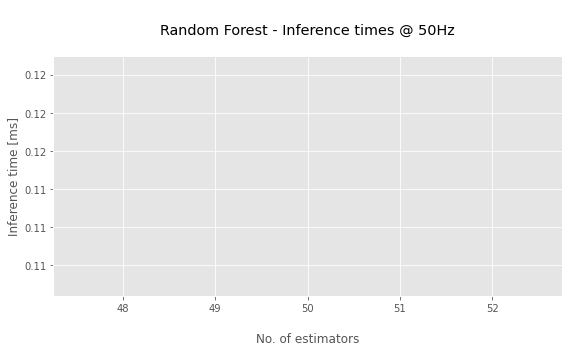

In [25]:
import matplotlib.ticker as tick

plt.figure(figsize=(8,5))
sns.lineplot(data=m2c_df[m2c_df['estimators'] < 100], x='estimators', y='random_forest')

plt.title('\nRandom Forest - Inference times @ 50Hz\n')
plt.xlabel('\nNo. of estimators')
plt.ylabel('Inference time [ms]')

plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x, post: f'{(x * 1000):.2f}'))
plt.tight_layout()